# Decoding Board from Data

In [205]:
#necessary imports
import pandas
import numpy as np
import tensorflow.keras as keras
from keras.models import Model
from keras.layers import Dense, Input
from IPython.display import display
import sympy as sp
sp.init_printing(use_latex = True)
import math

import matplotlib.pyplot as plt
%matplotlib inline

#retrieve vector data from gamestate
inputGamestate = np.array(pandas.read_table("nineFullData(2)_Validated.txt", delim_whitespace = True, header = None))

#Decoding Board From Data
board_size = 9 * 9
board_length = int(math.sqrt(board_size))
boardState = np.zeros((len(inputGamestate), int(math.sqrt(board_size)), int(math.sqrt(board_size))))

index_of_board = 0
for row in inputGamestate:
    index_of_row = 0
    index_of_column = 0
    for item in row:
        if(index_of_row != 3*board_size):
            tile = row[index_of_row : index_of_row + 3]
            if(tile[2] == 1):
                boardState[index_of_board][int(index_of_row/(int(board_length*3)))][index_of_column] = 0 #Tile is empty
            elif(tile[1] == 1):
                boardState[index_of_board][int(index_of_row/(int(board_length*3)))][index_of_column] = -1 #Black occupies this tile
            elif(tile[0] == 1):
                boardState[index_of_board][int(index_of_row/(int(board_length*3)))][index_of_column] = 1 #White occupies this tile
            index_of_row = index_of_row + 3
            index_of_column = index_of_column + 1
            if(index_of_column == board_length):
                index_of_column = 0
    boardState[index_of_board] = np.fliplr(boardState[index_of_board])
    index_of_board = index_of_board + 1


# Data Categorization and Assignment

In [206]:
train_data = X.shape[0]

X = X.reshape(train_data, board_length, board_length, 1)

#Coordinate of move made to achieve board state (bottom left of the board being 0, 0)
#coordinate = inputGamestate[:, 243:245]

#Legality checker for the move
#legal = inputGamestate[:, 245]

#Black or white to move from this position(-1 or 1 respectively)
#whoseTurn = inputGamestate[:, 246]

#Who won from this position (-1 or 1 respectively, 0 for play continues)
#whoWon = inputGamestate[:, 247]

#Move to be made from this powsition
playersMove = inputGamestate[:, 248]

#Input
#X = inputGamestate[:, :248]

#Creating 81 categories based on every spot on the board, 1 representing the move to be made
Y = keras.utils.to_categorical(playersMove, len(np.unique(playersMove)))

training_samples = int(0.7 * train_data)
X_train, X_test = X[:training_samples], X[training_samples:]
Y_train, Y_test = Y[:training_samples], Y[training_samples:]

# Building the Model

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_5 (ZeroPaddin (None, 9, 15, 7)          0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 9, 15, 48)         16512     
_________________________________________________________________
dense_154 (Dense)            (None, 9, 15, 1000)       49000     
_________________________________________________________________
dropout_12 (Dropout)         (None, 9, 15, 1000)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 7, 1000)        0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 4, 13, 1006)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 4, 13, 48)       

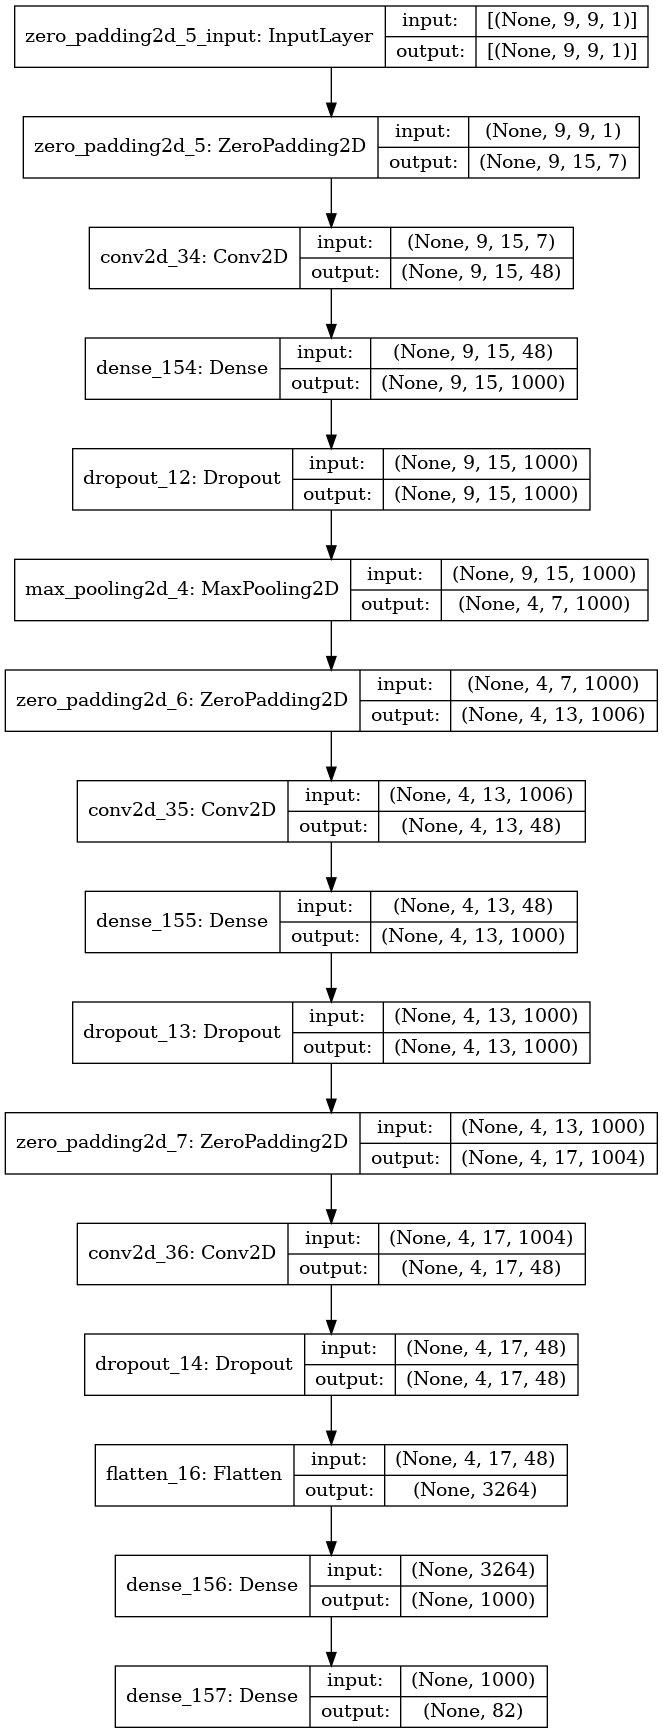

In [235]:
#defining input shape (board state)
#input_size = X.shape[1]

input_shape = (board_length, board_length, 1)
#defining output shape 
#output_size = Y.shape[1]
model = keras.models.Sequential()
model.add(keras.layers.ZeroPadding2D(padding = 3, input_shape = input_shape, data_format = 'channels_first'))
model.add(keras.layers.Conv2D(48, kernel_size = (7, 7), activation = 'relu', padding = 'same', input_shape = input_shape))
model.add(keras.layers.Dense(1000, activation = 'relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(keras.layers.ZeroPadding2D(padding = 3, input_shape = input_shape, data_format = 'channels_first'))
model.add(keras.layers.Conv2D(48, kernel_size = (5, 5), activation = 'relu', padding = 'same'))
model.add(keras.layers.Dense(1000, activation = 'relu'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.ZeroPadding2D(padding = 2, input_shape = input_shape, data_format = 'channels_first'))
model.add(keras.layers.Conv2D(48, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1000, activation = 'relu'))
model.add(keras.layers.Dense(board_size + 1, activation = 'softmax'))

#hidden1 = keras.layers.Dense(1000, activation = 'relu')(conv2D_1)
#hidden2 = keras.layers.Dense(1000, activation = 'relu')(hidden1)
#hidden3 = keras.layers.Dense(1000, activation = 'relu')(hidden2)
#drop1 = keras.layers.Dropout(0.2)(hidden3)
#hidden4 = keras.layers.Dense(1000, activation = 'relu')(drop1)
#hidden5 = keras.layers.Dense(1000, activation = 'relu')(hidden4)
#output = keras.layers.Dense(82, activation = 'softmax')(hidden5)
#model = Model(inputs = conv2D_1, outputs = output)

model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.Adam(), metrics = [keras.metrics.CategoricalAccuracy()])
model.summary()
keras.utils.plot_model(model, show_shapes = True, expand_nested = True, show_layer_names = True)

#0 if the game ends
#1 - 81
#row major order from top left, bottom right is 81

# Training

In [237]:
#Train the model
history = model.fit(X_train, Y_train, batch_size = 128, epochs = 10, verbose = 1, validation_data = (X_test, Y_test))

Epoch 1/10
2199/2199 [==============================] - 2385s 1s/step - loss: 3.8788 - categorical_accuracy: 0.0603 - val_loss: 3.5912 - val_categorical_accuracy: 0.1112
Epoch 2/10
2199/2199 [==============================] - 2355s 1s/step - loss: 3.4777 - categorical_accuracy: 0.1318 - val_loss: 3.3191 - val_categorical_accuracy: 0.1631
Epoch 3/10
2199/2199 [==============================] - 2341s 1s/step - loss: 3.2813 - categorical_accuracy: 0.1692 - val_loss: 3.1945 - val_categorical_accuracy: 0.1929
Epoch 4/10
2199/2199 [==============================] - 2344s 1s/step - loss: 3.1654 - categorical_accuracy: 0.1918 - val_loss: 3.1385 - val_categorical_accuracy: 0.2020
Epoch 5/10
2199/2199 [==============================] - 2342s 1s/step - loss: 3.0779 - categorical_accuracy: 0.2081 - val_loss: 3.1007 - val_categorical_accuracy: 0.2096
Epoch 6/10
2199/2199 [==============================] - 2497s 1s/step - loss: 3.0114 - categorical_accuracy: 0.2209 - val_loss: 3.0589 - val_categoric

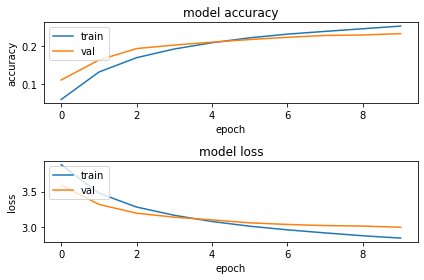

In [238]:
plt.figure(1)

plt.subplot(211)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [239]:
model.save_weights('weights.h5')